In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
import torchvision.models as models
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch_geometric.nn as g_nn
from torch_geometric.data import Data

In [52]:
data = pd.read_csv( '../data/cassava-leaf-disease-classification/train.csv' )
data

,image_id,label
0,1000015157.jpg,0
1,1000201771.jpg,3
2,100042118.jpg,1
3,1000723321.jpg,1
4,1000812911.jpg,3
...,...,...
21392,999068805.jpg,3
21393,999329392.jpg,3
21394,999474432.jpg,1
21395,999616605.jpg,4


In [53]:
data_id = data[ 'image_id' ].values
data_label = data[ 'label' ].values
data_len = len( data_label )
data_id.shape, data_label.shape, data_len

((21397,), (21397,), 21397)

In [54]:
num_0 = ( data_label == 0 ).sum()
num_1 = ( data_label == 1 ).sum()
num_2 = ( data_label == 2 ).sum()
num_3 = ( data_label == 3 ).sum()
num_4 = ( data_label == 4 ).sum()

num_0, num_1, num_2, num_3, num_4

(1087, 2189, 2386, 13158, 2577)

In [55]:
pre_load = {
    'train': transforms.Compose( [ transforms.RandomResizedCrop( 224 ),
                                   transforms.RandomHorizontalFlip(),
                                   transforms.ToTensor(),
                                   transforms.Normalize( ( 0.5, 0.5, 0.5 ), ( 0.5, 0.5, 0.5 ) ) ] 
                                 ),
    'test': transforms.Compose( [ transforms.Resize( ( 244, 244 ) ),
                                  transforms.ToTensor(),
                                  transforms.Normalize( ( 0.5, 0.5, 0.5 ), ( 0.5, 0.5, 0.5 ) ) ]
                                ),
}


train_dataset = datasets.ImageFolder( root = '../data/train_photos', transform = pre_load[ 'train' ] )
test_dataset = datasets.ImageFolder( root = '../data/test_photos', transform = pre_load[ 'test' ] )
train_num, test_num = len( train_dataset ), len( test_dataset )

train_num, test_num

(19261, 2136)

In [56]:
batch_size = 32

train_loader = DataLoader( train_dataset, batch_size = batch_size, shuffle = True )
test_loader = DataLoader( test_dataset, batch_size = batch_size, shuffle = False )

In [3]:
class Net( nn.Module ):
    def __init__( self, res, gcn ):
        super( Net, self ).__init__()
        self.resnet = nn.Sequential( *list( res.children())[:-1] )
        self.fc_resnet = nn.Linear( res.fc.in_features, 64 )
        self.gcn = gcn
        self.fc = nn.Linear( gcn.out_channels, 5 )
        
    def forward( self, image, edge_index ):
        x = self.resnet( image )
        x = x.view(x.size(0), -1)
        x = self.fc_resnet(x)
        data = Data( x = x, edge_index = edge_index )
        x = self.gcn( data.x, data.edge_index )
        x = self.fc( x )
        return x
        

In [4]:
num_classes = 5

res = models.resnet34( pretrained = True )
gcn = g_nn.GCNConv( in_channels = 64, out_channels = num_classes )

C:\Users\EC319\AppData\Roaming\Python\Python311\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\EC319\AppData\Roaming\Python\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [59]:
def generate_edge_index( labels ):
    edge_index = []
    num_nodes = len( labels )
    for i in range( num_nodes ):
        for j in range( num_nodes ):
            if i != j and labels[i] == labels[j]:
                edge_index.append( [i, j] )
    edge_index = torch.tensor( edge_index, dtype=torch.long ).t().contiguous()
    return edge_index

In [ ]:
def create_edge( labels ):
    edge_index = []
    nodes = len( labels )
    for i in range( nodes ):
        for j in range( nodes ):
            if i != j and labels[i] == labels[j]:
                edge_index.append( [i, j] )
    edge_index = torch.tensor( edge_index, dtype=torch.long ).t().contiguous()
    return edge_index

In [8]:
net = Net( res, gcn )
loss_f = nn.CrossEntropyLoss()
optimizer = optim.Adam( net.parameters(), lr = 0.01 )


In [60]:
train_steps = len( train_loader )

for epoch in range( 5 ):
    net.train()
    running_loss = 0.0
    for step, data in enumerate( train_loader, start = 0 ):
        imgs, labels = data
        rate = ( ( step + 1 ) / train_steps )
        optimizer.zero_grad()
        edge_index = generate_edge_index( labels )
        output = net( imgs, edge_index )
        loss = loss_f( output, labels )
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
        a = '*' * int( rate * 50 )
        b = '.' * int( ( 1 - rate ) * 50 )
        print( '\r train loss: {:^3.0f}%[ {} -> {} ]{:.3f}'.format( int( rate * 100 ),a, b, loss ), end = '' )
    print()
    
    net.eval()
    r = 0.0
    best_R = 0.0
    with torch.no_grad():
        for data_test in test_loader:
            t_img, t_lbl = data_test
            edge_index = generate_edge_index( t_lbl )
            outputs = net( t_img, edge_index )
            pred_y = torch.max( outputs, dim = 1 )[1]
            r += ( pred_y == t_lbl ).sum().item()
        acc_R = r / test_num
        if acc_R > best_R:
            best_R = acc_R
            torch.save( net.state_dict(), '../path/ResNetGCN_best.pth' )                # 随时记录最最优训练结果
        print( '[epoch %d] train_loss: %.3f    test_accuracy: %.3f' % ( epoch + 1, running_loss, acc_R ) )
        
        
    print( 'finished' )


 train loss: 100%[ ************************************************** ->  ]0.532
[epoch 1] train_loss: 575.294    test_accuracy: 0.685
finished
 train loss: 100%[ ************************************************** ->  ]0.689
[epoch 2] train_loss: 407.911    test_accuracy: 0.538
finished
 train loss:  0 %[  -> ................................................. ]0.259

KeyboardInterrupt: 

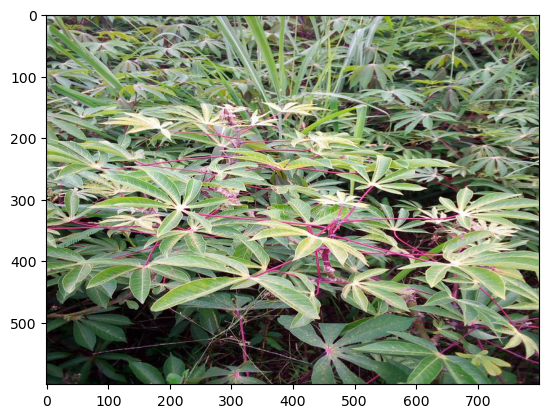

In [5]:
from PIL import Image

img_transform = transforms.Compose( [ transforms.Resize( ( 224, 224 ) ),
                                      transforms.ToTensor(),
                                      transforms.Normalize( ( 0.5, 0.5, 0.5 ), ( 0.5, 0.5, 0.5 ) ) ] 
                                    )
img = Image.open( '../data/cassava-leaf-disease-classification/test_images/2216849948.jpg' )
plt.imshow( img )

In [6]:
import json

img = img_transform( img )
img = torch.unsqueeze( img, dim = 0 )

with open( '../data/cassava-leaf-disease-classification/label_num_to_disease_map.json', 'r' ) as f:
    sorted_class = json.load( f )
print( sorted_class )

{'0': 'Cassava Bacterial Blight (CBB)', '1': 'Cassava Brown Streak Disease (CBSD)', '2': 'Cassava Green Mottle (CGM)', '3': 'Cassava Mosaic Disease (CMD)', '4': 'Healthy'}


In [10]:
def generate_edge_index2(batch_size):
    row = []
    col = []
    for i in range(batch_size):
        for j in range(batch_size):
            if i != j:
                row.append(i)
                col.append(j)
    edge_index = torch.tensor([row, col], dtype=torch.long)
    return edge_index

In [11]:
net.load_state_dict( torch.load( '../path/ResNetGCN_best.pth' ) )
net.eval()

with torch.no_grad():
    edge_index = generate_edge_index2( img.size( 0 ) )
    output = torch.squeeze( net( img, edge_index ) )
    predict = torch.softmax( output, dim = 0 )
    p_class = torch.argmax( predict ).numpy()
    print( p_class, sorted_class[ str( p_class ) ], predict[ p_class ].item() )

2 Cassava Green Mottle (CGM) 0.6080695986747742
